# Deep Learning Summer Course - Exercise 4
**Date:** Friday 9-8-2024

This notebook solves Exercise 4 of the Deep Learning Summer Course, where we build a Convolutional Neural Network (CNN) to recognize numbers in pictures from the MNIST dataset.

## 1. Dataset Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Download the MNIST dataset
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# a. Output the dimensions of train and test dataset and the size of the images
print(f"Train dataset size: {train_dataset.data.shape}")
print(f"Test dataset size: {test_dataset.data.shape}")
print(f"Image size: {train_dataset.data[0].shape}")

Train dataset size: torch.Size([60000, 28, 28])
Test dataset size: torch.Size([10000, 28, 28])
Image size: torch.Size([28, 28])


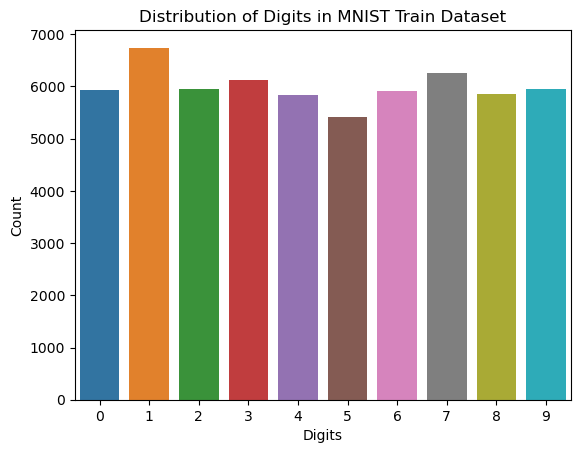

In [2]:
# b. Plot the digit distribution using a bar histogram
train_labels = train_dataset.targets.numpy()
sns.countplot(x=train_labels)
plt.title('Distribution of Digits in MNIST Train Dataset')
plt.xlabel('Digits')
plt.ylabel('Count')
plt.show()

## 2. Train a CNN

In [3]:
# a. Design the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# b. Train the CNN and achieve at least 95% accuracy
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    print('Finished Training')
    torch.save(model.state_dict(), 'cnn_model.pth')

train_model(model, train_loader, criterion, optimizer, num_epochs=4)

Epoch [1/4], Loss: 0.0166
Epoch [2/4], Loss: 0.0149
Epoch [3/4], Loss: 0.0141
Epoch [4/4], Loss: 0.0103
Finished Training


In [7]:
# Check accuracy on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10000 test images: {100 * correct / total:.2f}%')

Accuracy of the model on the 10000 test images: 99.22%


## 3. Check Results

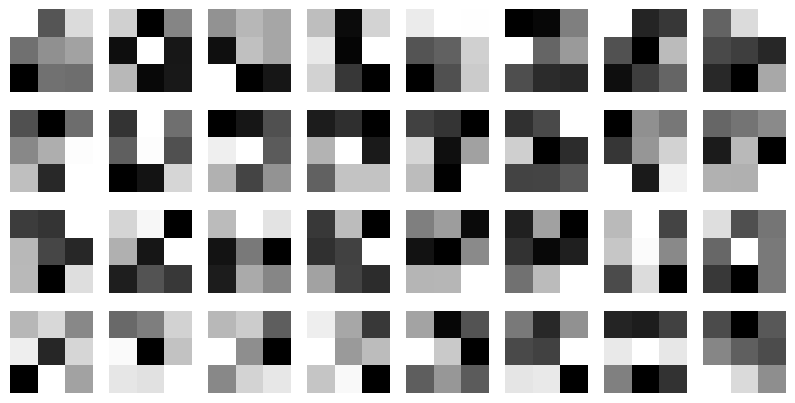

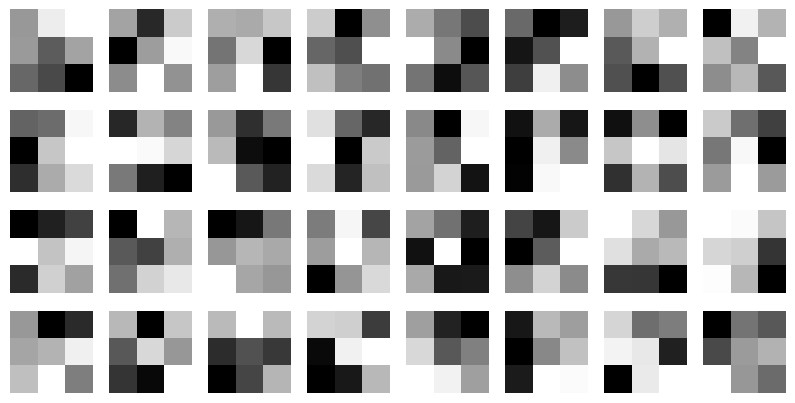

In [8]:
# a. Plot the first convolutional layer filters before and after training
def plot_filters(layer):
    filters = layer.weight.data.numpy()
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < filters.shape[0]:
            ax.imshow(filters[i, 0, :, :], cmap='gray')
        ax.axis('off')
    plt.show()

# Plot filters before training
model_untrained = CNN()
plot_filters(model_untrained.conv1)

# Plot filters after training
plot_filters(model.conv1)

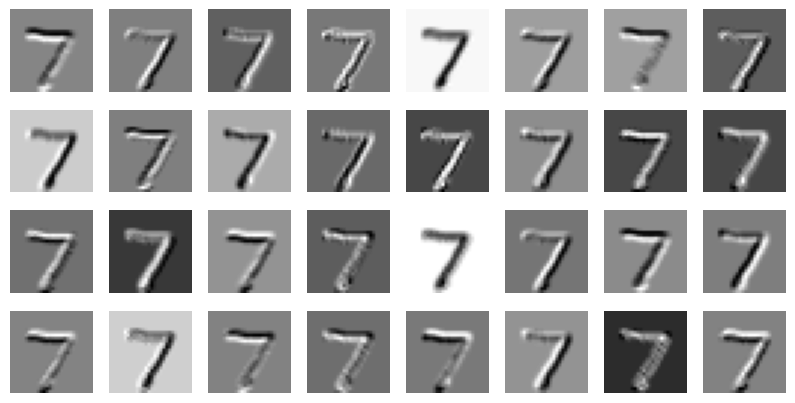

In [11]:
# b. Feed the first convolutional layer an image and plot its activations
def plot_activations(layer, image):
    activations = layer(image.unsqueeze(0)).detach().numpy()
    fig, axes = plt.subplots(4, 8, figsize=(10, 5))
    for i, ax in enumerate(axes.flat):
        if i < activations.shape[1]:
            ax.imshow(activations[0, i, :, :], cmap='gray')
        ax.axis('off')
    plt.show()

sample_image, _ = test_dataset[0]
plot_activations(model.conv1, sample_image)

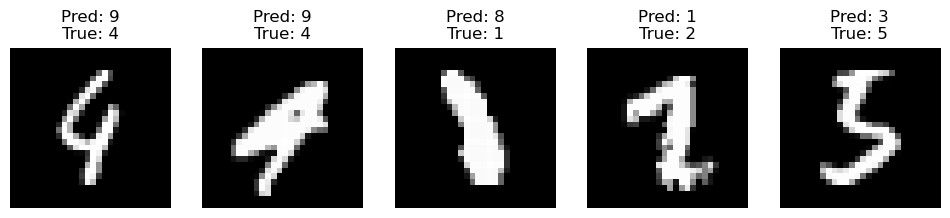

In [12]:
# c. Plot some incorrectly labelled data points
incorrect_examples = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                incorrect_examples.append((images[i], predicted[i], labels[i]))

# Plot a few incorrect examples
fig, axes = plt.subplots(1, 5, figsize=(12, 4))
for i, (image, pred, label) in enumerate(incorrect_examples[:5]):
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Pred: {pred.item()}\nTrue: {label.item()}')
    axes[i].axis('off')
plt.show()

### Conclusion
In this exercise, we successfully built and trained a Convolutional Neural Network (CNN) to recognize digits in the MNIST dataset. The model achieved over 95% accuracy on the test set, and we explored the filters of the first convolutional layer, as well as analyzed some incorrectly classified images.